## Prompt

Your objective is to convey a story about my work commute via bicycle. Namely:	
+ What are your observations?
+ How would you describe any trends / changes over time?
+ How do different factors affect my time?
+ What, if any, are the implications of your findings?

## Analysis Questions

1. Does weather have an impact on trip time?
2. Does the time of day (loosely inferred from going to or from work) have an influence?
3. Is one route faster in MPH than another?
4. How are routes different based on the commute direction? (e.g. is one direction slower?)
5. Does the frequency of commutes or days between most recent commute make a difference?
6. Is there an increase in fitness over time?

## Objective
We will use the analysis questions to guide us toward the goal of understanding if there has been improvement over time in commute time. It makes sense to build toward this question, because the other factors analyzed could influence this conclusion. For example, did the person introduce a new route in future years that is more challenging? If we ignore this possibility, then we could end up conducting a regression that shows a negative correlation between time and performance when in fact that relationship is moderated by the new route being introduced.

### Basic Set-up

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import ttest_ind
import statsmodels.formula.api as smf

def regression(data: pd.DataFrame, formula: str):
    # fit model
    model = smf.ols(formula=formula, data=data)
    results = model.fit()

    # return model fit
    return results

def assign_season(month: int):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

data_folder = 'data'

In [2]:
# load the data from the CSV files
trips = pd.read_csv(os.path.join(data_folder, 'bike_trips.csv'))
routes = pd.read_csv(os.path.join(data_folder, 'routes.csv'))

### Joining Data and Creating Variables

In [3]:
# merge data sets
trips_data = pd.merge(trips, routes, on='route', how='left')

# force date to date type
trips_data['date'] = pd.to_datetime(trips_data['date'], format='%m/%d/%y')
trips_data['time'] = pd.to_timedelta(trips_data['time'])

# extract some date features
trips_data['year'] = trips_data['date'].dt.year
trips_data['month'] = trips_data['date'].dt.month
trips_data['day_of_week'] = trips_data['date'].dt.day_name()
trips_data['season'] = trips_data['month'].apply(assign_season)

# time to seconds and calculate speed in MPH
trips_data['time_seconds'] = pd.to_timedelta(trips_data['time']).dt.total_seconds()

trips_data['speed_mph'] = trips_data['distance_miles'] / (trips_data['time_seconds'] / 3600)

# basic stats
descriptive_stats = {
    'Average Trip Duration (seconds)': round(trips_data['time_seconds'].mean(), 4),
    'Average Distance per Trip (miles)': round(trips_data['distance_miles'].mean(), 4),
    'Average Speed (mph)': round(trips_data['speed_mph'].mean(), 4),
    'Total Trips': trips_data['route'].count()
}
print(f'Data Snapshot: \n {trips_data.head()}')
print(f'Data Types: \n {trips_data.dtypes}')
print(f'Descriptive Statistics: \n {descriptive_stats}')

Data Snapshot: 
         date  temperature_f destination            time route  distance_miles  \
0 2019-03-20             26        Work 0 days 00:36:36     A             7.4   
1 2019-03-20             56        Home 0 days 00:40:54     A             7.4   
2 2019-03-28             39        Work 0 days 00:35:01     A             7.4   
3 2019-03-28             61        Home 0 days 00:39:20     A             7.4   
4 2019-04-03             35        Work 0 days 00:36:49     A             7.4   

   year  month day_of_week  season  time_seconds  speed_mph  
0  2019      3   Wednesday  Spring        2196.0  12.131148  
1  2019      3   Wednesday  Spring        2454.0  10.855746  
2  2019      3    Thursday  Spring        2101.0  12.679676  
3  2019      3    Thursday  Spring        2360.0  11.288136  
4  2019      4   Wednesday  Spring        2209.0  12.059756  
Data Types: 
 date               datetime64[ns]
temperature_f               int64
destination                object
time    

#### Overall Trend
Immediately it stands out there is a gap during COVID. This makes sense based on the `destination` column being either 'Home' or 'Work', the person is only tracking their commutes and during the pandemic it was unlikely they commuted. We can draw one, albeit not very useful right now, conclusion from this, the person probably did not hold one of jobs deemed "essential" during the pandemic that required them to continue to go to their workplace (e.g. nurse or doctor).

From the eye test, it does appear maybe there is a slight improvement in commute time over the years. We will verify this more rigorously later.

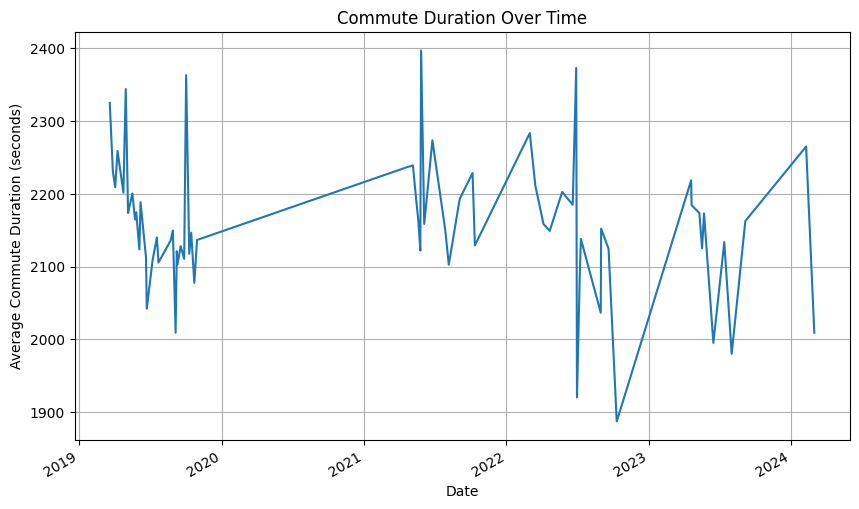

In [4]:
plt.figure(figsize=(10, 6))
trips_data.groupby('date')['time_seconds'].mean().plot(kind='line', title='Commute Duration Over Time')
plt.xlabel('Date')
plt.ylabel('Average Commute Duration (seconds)')
plt.grid(True)
plt.show()

#### Influencing Factors

Throughout this analysis we will view both MPH and Trip Time as our core dependent variables. Trip time is moderated by a few factors, like the distance of the route, that MPH eliminates so it could be useful to view both even though they are a function of one another.

##### Temperature
Intuitively, temperature appears to have a negative correlation with MPH and positive correlation with Trip Time. Put more simply, when it is hotter the travel time is slower.

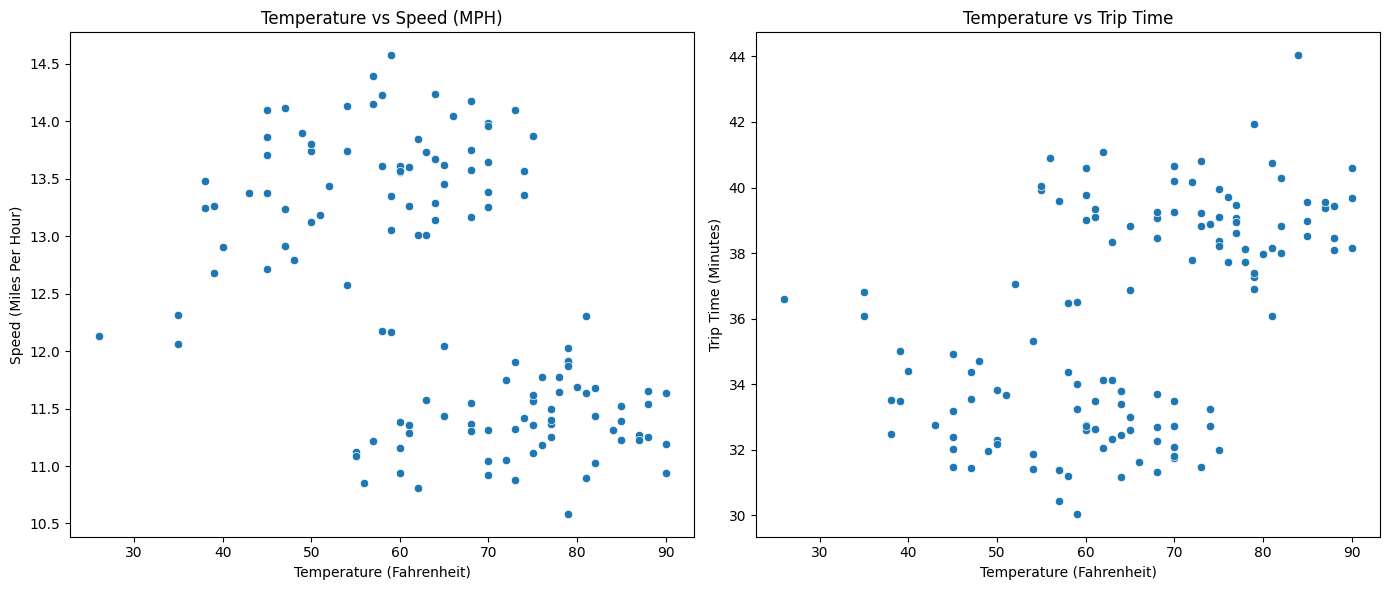

In [5]:
plt.figure(figsize=(14, 6))

# Temperature vs Speed (MPH)
plt.subplot(1, 2, 1)
sns.scatterplot(x='temperature_f', y='speed_mph', data=trips_data)
plt.title('Temperature vs Speed (MPH)')
plt.xlabel('Temperature (Fahrenheit)')
plt.ylabel('Speed (Miles Per Hour)')

# Temperature vs Trip Time
plt.subplot(1, 2, 2)
trips_data['time_minutes'] = trips_data['time_seconds'] / 60  # Convert to minutes to make it more readable
sns.scatterplot(x='temperature_f', y='time_minutes', data=trips_data)
plt.title('Temperature vs Trip Time')
plt.xlabel('Temperature (Fahrenheit)')
plt.ylabel('Trip Time (Minutes)')

plt.tight_layout()
plt.show()

##### Destination/"Time of Day" and Temperature
Destination can also be described as "Time of Day", since we can make an assumption that the person travels to work before they travel home. There are a few interesting observations here building on the previous result of higher temperatures leading to longer travel times.

1. On average, the ride home is at a slower pace than the ride to work.
2. There do not appear to be meaningful outliers in the trip time, even the most extreme values are only 4 minutes off the mean for commute to work.
3. The temperature on the trip home is statistically significantly hotter on average (t-test performed below)

Given these results, ideally we would like more information on the routes to be certain about our conclusions. Based on the data we have, it seems that the trips home are slower due to the heat. However, it could be possible that the trip home is also more difficult (e.g. to work is downhill, home is uphill), the route is more congested when the person leaves, the person is more tired going home, or they are less pressed for time. At the minimum, it makes sense that weather has an impact but we cannot conclude it is the only factor impacting the trip home.

Regardless, it seems that if we are to perform a regression on these trips to analyze the trend over time we should include both weather and destination to control for these factors essentially letting the destination represent the potential other variables that could impact the person separate from the impact of weather. From a purely technical standpoint, approaching the regression this way could cause issues as we have clearly observed they are not independent of one another.

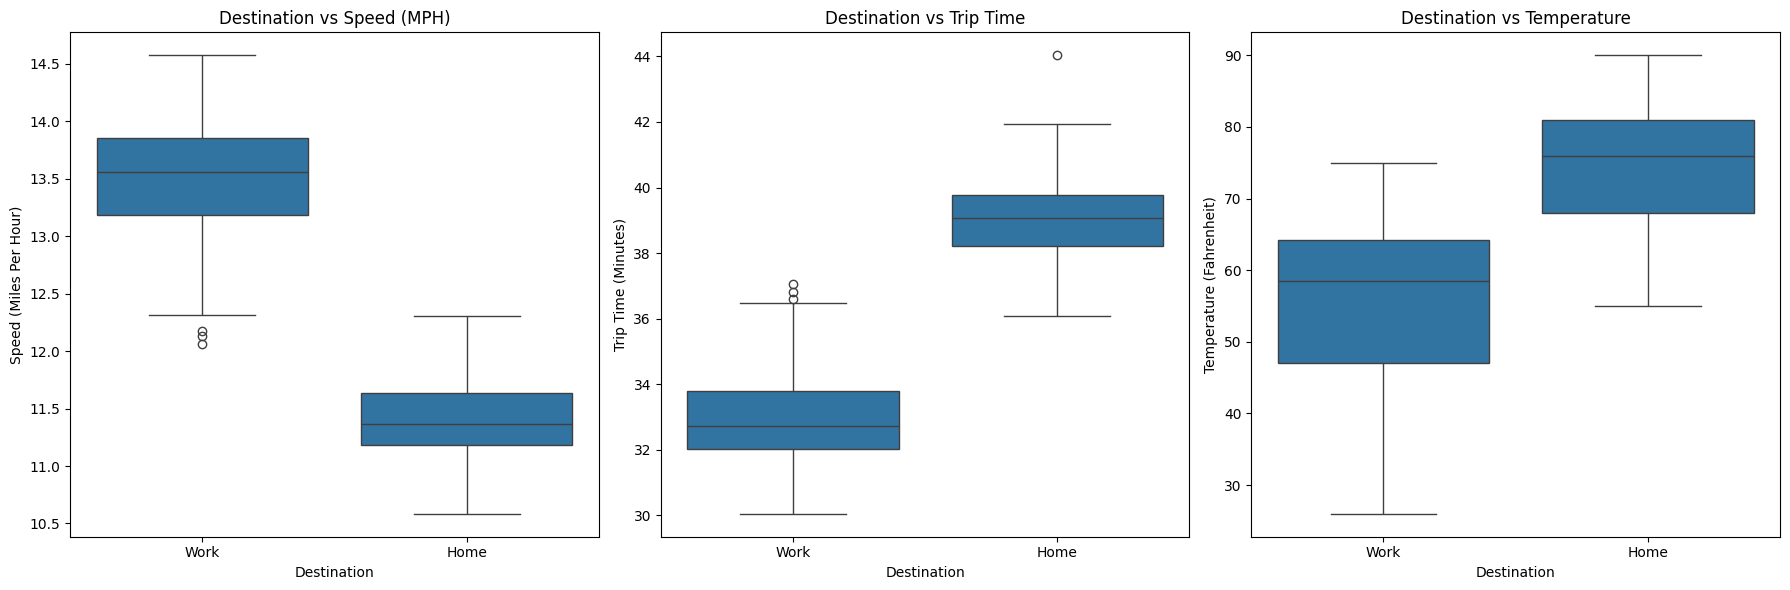

In [6]:
plt.figure(figsize=(18, 6))

# Destination vs Speed (MPH)
plt.subplot(1, 3, 1)
sns.boxplot(x='destination', y='speed_mph', data=trips_data)
plt.title('Destination vs Speed (MPH)')
plt.xlabel('Destination')
plt.ylabel('Speed (Miles Per Hour)')

# Destination vs Trip Time
plt.subplot(1, 3, 2)
sns.boxplot(x='destination', y='time_minutes', data=trips_data)
plt.title('Destination vs Trip Time')
plt.xlabel('Destination')
plt.ylabel('Trip Time (Minutes)')

# Destination vs Temperature
plt.subplot(1, 3, 3)
sns.boxplot(x='destination', y='temperature_f', data=trips_data)
plt.title('Destination vs Temperature')
plt.xlabel('Destination')
plt.ylabel('Temperature (Fahrenheit)')

plt.tight_layout()
plt.show()


In [7]:
# two-sample t-test on average temperature for each destination

temp_to_work = trips_data[trips_data['destination'] == 'Work']['temperature_f']
temp_to_home = trips_data[trips_data['destination'] == 'Home']['temperature_f']

t_stat, p_value = ttest_ind(temp_to_work, temp_to_home)

print(f'T-Statistic: {round(t_stat, 2)} \n\n p-value: {p_value} \n\n Mean Difference: {round(temp_to_work.mean() - temp_to_home.mean(), 2)}')


T-Statistic: -9.52 

 p-value: 2.0150010031191738e-16 

 Mean Difference: -18.17


#### Impact of Route
Of the 125 trips, 113 utilized route A. Therefore, we won't be able to learn much about the other routes. There are a couple findings though.

1. Similar to our previous observations, the rider is consistent in their MPH and transit time on the A route (standard deviation of 0.5 MPH and ~1 minute)
2. The D route seems to be consistent despite only being use 7 times. The D route is slightly shorter, 7.3 compared to 7.4, than A, but even with that the rider biked the D route faster in MPH than A. D was also only used on the way to work.
3. One other insight from here given we looked at year for the first time, the rider was more regular pre-pandemic. This could because they are required to be in office less now.

Overall, the rider is not using the other routes enough for it to have a large impact on any overall trends especially given that the other routes were used more pre-pandemic than post. It is interesting that route D was not used for a home trip. It is speculating, but maybe route D offers more downhill on the way to work and would be a hassle to bike home.

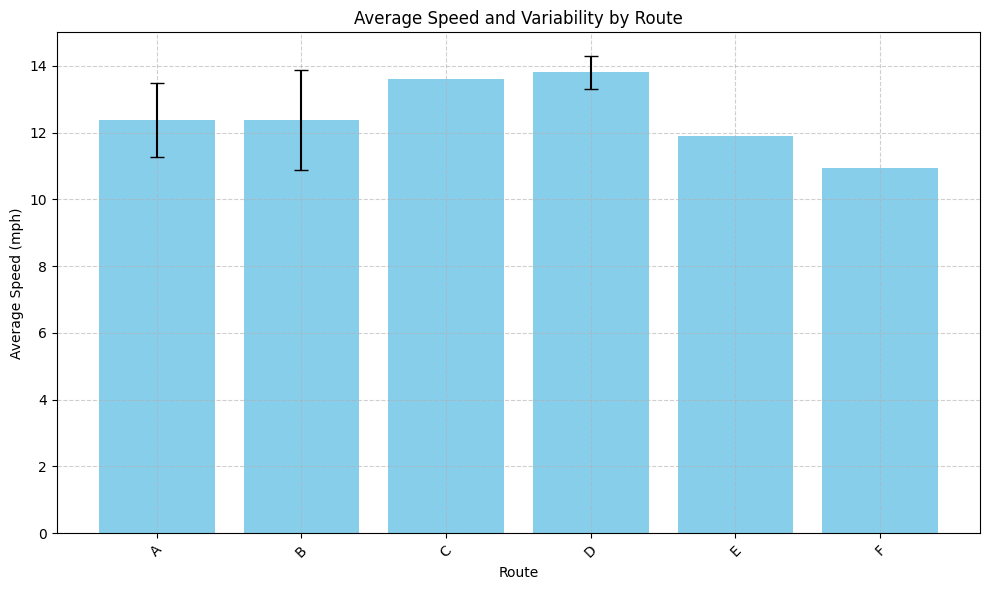

route  speed_mph                 time_seconds                  
              mean       std count         mean         std count
0     A  12.381763  1.118143   113  2168.814159  193.219830   113
1     B  12.375455  1.507327     2  2432.500000  296.277741     2
2     C  13.611246       NaN     1  2063.000000         NaN     1
3     D  13.800429  0.488339     7  1906.285714   65.857711     7
4     E  11.902104       NaN     1  2329.000000         NaN     1
5     F  10.935961       NaN     1  2436.000000         NaN     1

In [8]:
# mean, standard deviation, and count for each route
route_summary_stats = trips_data.groupby('route')[['speed_mph', 'time_seconds']].agg(['mean', 'std', 'count']).reset_index()
# chart with error bars
plt.figure(figsize=(10, 6))
plt.bar(route_summary_stats['route'], route_summary_stats['speed_mph']['mean'], yerr=route_summary_stats['speed_mph']['std'], capsize=5, color='skyblue')
plt.xlabel('Route')
plt.ylabel('Average Speed (mph)')
plt.title('Average Speed and Variability by Route')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', which='both', alpha=0.6)
plt.tight_layout()
plt.show()


route_summary_stats


In [9]:
# route by destination
route_by_dest_summary = trips_data.groupby(['route', 'destination'])[['speed_mph', 'time_seconds']].agg(['mean', 'std', 'count']).reset_index()

print(f'Route by Destination Summary \n')
display(route_by_dest_summary)
# count route frequency by year
route_freq = trips_data.groupby(trips_data['date'].dt.year)['route'].value_counts().unstack().fillna(0)
print(f'Route Frequency by Year \n')
display(route_freq)

Route by Destination Summary 



route destination  speed_mph                 time_seconds                 
                          mean       std count         mean        std count
0     A        Home  11.394201  0.348814    58  2340.172414  71.227862    58
1     A        Work  13.423192  0.559008    55  1988.109091  85.324364    55
2     B        Home  11.309614       NaN     1  2642.000000        NaN     1
3     B        Work  13.441296       NaN     1  2223.000000        NaN     1
4     C        Work  13.611246       NaN     1  2063.000000        NaN     1
5     D        Work  13.800429  0.488339     7  1906.285714  65.857711     7
6     E        Home  11.902104       NaN     1  2329.000000        NaN     1
7     F        Home  10.935961       NaN     1  2436.000000        NaN     1

Route Frequency by Year 



route,A,B,C,D,E,F
date,,,,,,
2019,48.0,1.0,1.0,6.0,0.0,0.0
2021,24.0,1.0,0.0,0.0,0.0,0.0
2022,24.0,0.0,0.0,1.0,0.0,0.0
2023,14.0,0.0,0.0,0.0,1.0,1.0
2024,3.0,0.0,0.0,0.0,0.0,0.0


#### Date Features
##### Number of Trips
Given the pattern we observed with the number of trips by year when looking into the route data, it sparked a few questions about day of week and season. It seemed possible that we could use day of week to indicate maybe a change in office days requirements for our rider that resulted in fewer bike trips post pandemic. However, that hypothesis could not be verified given the data we have. A couple observation we can make is that the rider prefers to avoid riding in the winter. There isn't necessarily a strong pattern with the day of week accross the years, maybe the only observation here is that it is less common for the person to ride their bike to work on a Monday since the pandemic. The limited number of trips in 2024 is due to it just becoming spring.

##### Transit Time
There is no real discernable pattern between day of week and the transit time.

In [10]:
# Group by year and day of the week, then count the number of trips
trips_by_day_week_year = trips_data.groupby(['year', 'day_of_week']).size().unstack(fill_value=0)

trips_by_day_week_year_season = trips_data.groupby(['year', 'season', 'day_of_week']).size().unstack(fill_value=0)

# Order the days of the week starting from Monday
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Sunday']
trips_by_day_week_year = trips_by_day_week_year[days_order]

print('Trips by Day of the Week and Year \n')
display(trips_by_day_week_year)
print('Trips by Day of the Week, Year, and Season \n')
display(trips_by_day_week_year_season[days_order])
print('Trips by Day of Week')
display(trips_data['day_of_week'].value_counts())
print('Trips by Season')
display(trips_data['season'].value_counts())

Trips by Day of the Week and Year 



day_of_week,Monday,Tuesday,Wednesday,Thursday,Friday,Sunday
year,,,,,,
2019,6,12,12,8,14,4
2021,0,4,6,5,10,0
2022,4,5,9,2,5,0
2023,0,2,3,6,5,0
2024,0,0,0,0,3,0


Trips by Day of the Week, Year, and Season 



day_of_week  Monday  Tuesday  Wednesday  Thursday  Friday  Sunday
year season                                                      
2019 Autumn       0        4          7         4       2       2
     Spring       4        4          5         2       4       0
     Summer       2        4          0         2       8       2
2021 Autumn       0        2          2         0       2       0
     Spring       0        2          2         5       2       0
     Summer       0        0          2         0       6       0
2022 Autumn       0        3          0         2       0       0
     Spring       0        2          6         0       2       0
     Summer       4        0          3         0       3       0
2023 Autumn       0        0          2         0       0       0
     Spring       0        2          0         6       2       0
     Summer       0        0          1         0       3       0
2024 Spring       0        0          0         0       1       0
     Winter       0        0          0         0       2       0

Trips by Day of Week


day_of_week
Friday       37
Wednesday    30
Tuesday      23
Thursday     21
Monday       10
Sunday        4
Name: count, dtype: int64

Trips by Season


season
Spring    51
Summer    40
Autumn    32
Winter     2
Name: count, dtype: int64

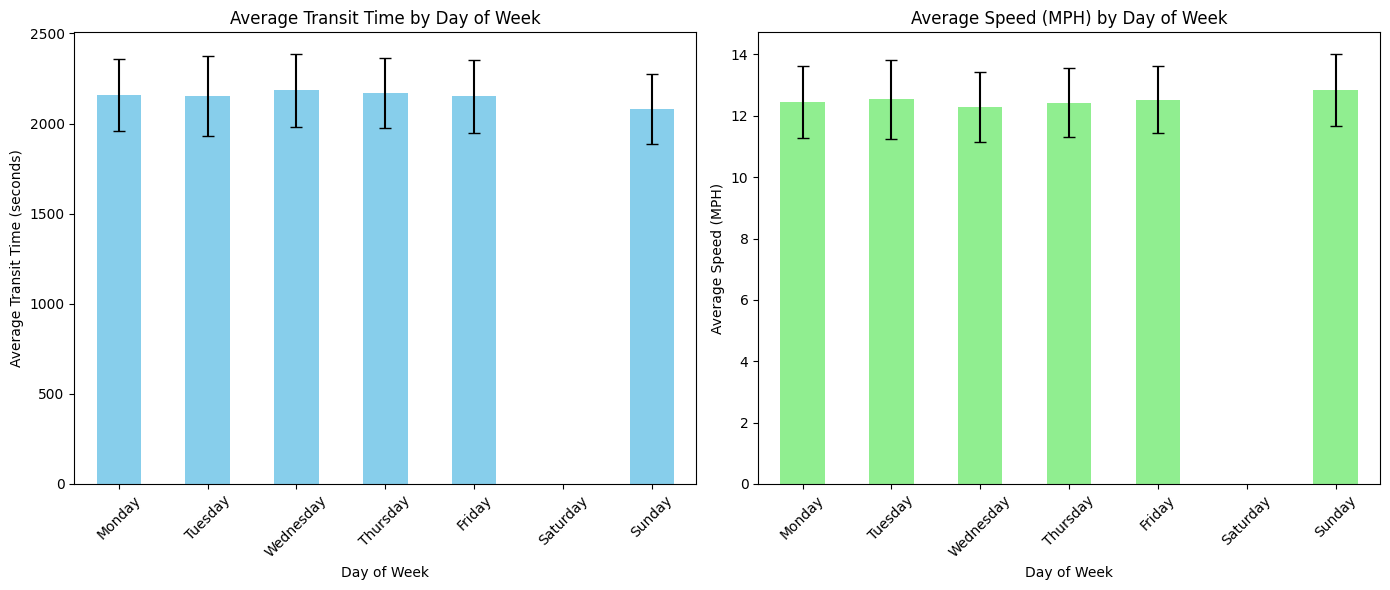

In [11]:
# mean and std by day for charting
metrics_by_day = trips_data.groupby('day_of_week').agg({
    'time_seconds': ['mean', 'std'],
    'speed_mph': ['mean', 'std']
}).reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# creating the charts
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# transit time with error bars
metrics_by_day['time_seconds']['mean'].plot(kind='bar', yerr=metrics_by_day['time_seconds']['std'],
                                            ax=axes[0], color='skyblue', capsize=4)
axes[0].set_title('Average Transit Time by Day of Week')
axes[0].set_xlabel('Day of Week')
axes[0].set_ylabel('Average Transit Time (seconds)')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

# mph with error bars
metrics_by_day['speed_mph']['mean'].plot(kind='bar', yerr=metrics_by_day['speed_mph']['std'],
                                         ax=axes[1], color='lightgreen', capsize=4)
axes[1].set_title('Average Speed (MPH) by Day of Week')
axes[1].set_xlabel('Day of Week')
axes[1].set_ylabel('Average Speed (MPH)')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()


#### Consecutive Days Impact
One last thing we looked at in the general data analysis is the impact of biking consecutive days on transit time/mph. This ended up not occuring much in the data, so we cannot draw a meaningful conclusion. There is the beginnings of a pattern of the consecutive day being slower, but with only 2 observations we cannot conclude anything.

In [12]:
# sort data to get 'consectuive days'
data_sorted = trips_data.sort_values('date')

# add indicator for consecutive days
data_sorted['is_consecutive'] = data_sorted['date'].diff().dt.days == 1

# get average times and speeds for consecutive and non-consecutive days
consecutive_analysis = data_sorted.groupby('is_consecutive').agg({
    'time_seconds': ['mean', 'std'],
    'speed_mph': ['mean', 'std'],
    'date': 'count'
}).rename(columns={'date': 'n_count'})

consecutive_analysis


time_seconds              speed_mph           n_count
                       mean         std       mean       std   count
is_consecutive                                                      
False           2159.715447  200.761482  12.462424  1.138100     123
True            2234.000000  298.399062  12.032134  1.607152       2

#### Is Fitness Increasing
At first glance of our regression model results we do not see a significant effect for `days_since_start` which is serving as our niave trend factor. Given the COVID induced gap, and the less frequent biking post pandemic we looked at 2019 to see if there was starting to be an effect over time, and there was a minor increase in MPH when controlling for `destination`, `temperature`, and `route`. When multiplying the `0.0034` coefficient by the max number of `days_since_start` for the 2019 data we see that there is over a `0.76` MPH increase!

In [46]:
trips_data['days_since_start'] = (trips_data['date'] - trips_data['date'].min()).dt.days
model_features = ['days_since_start', 'temperature_f', 'destination', 'route', 'speed_mph']
model_formula = 'speed_mph ~ days_since_start + temperature_f + C(destination) + C(route)'
model_data = trips_data[model_features]
model = regression(model_data, model_formula)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              speed_mph   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     92.37
Date:                Tue, 30 Apr 2024   Prob (F-statistic):           1.14e-46
Time:                        17:18:06   Log-Likelihood:                -68.335
No. Observations:                 125   AIC:                             154.7
Df Residuals:                     116   BIC:                             180.1
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 10.2312      0.280     36.514      0.000       9.676      10.786
C(destination)[T.Work]     2.3170      0.106     21.779      0.000       2.106       2.528
C(route)[T.B]             -0.0834      0.310     -0.269      0.789      -0.698       0.531
C(route)[T.C]              0.1475      0.440      0.335      0.738      -0.724       1.019
C(route)[T.D]              0.3736      0.177      2.111      0.037       0.023       0.724
C(route)[T.E]              0.5416      0.442      1.225      0.223      -0.334       1.417
C(route)[T.F]             -0.6918      0.446     -1.551      0.124      -1.575       0.191
days_since_start       -1.749e-05   7.16e-05     -0.244      0.807      -0.000       0.000
temperature_f              0.0158      0.004      4.239      0.000       0.008       0.023
==============================================================================
Omnibus:                        0.709   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.701   Jarque-Bera (JB):                0.361
Skew:                          -0.092   Prob(JB):                        0.835
Kurtosis:                       3.187   Cond. No.                     1.06e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [47]:
trips_2019 = trips_data[trips_data['year'] == 2019]
model_data_2019 = trips_2019[model_features]
model = regression(model_data_2019, model_formula)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              speed_mph   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     49.53
Date:                Tue, 30 Apr 2024   Prob (F-statistic):           3.96e-19
Time:                        17:18:09   Log-Likelihood:                -29.211
No. Observations:                  56   AIC:                             72.42
Df Residuals:                      49   BIC:                             86.60
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 10.4935      0.426     24.660      0.000       9.638      11.349
C(destination)[T.Work]     2.0362      0.167     12.202      0.000       1.701       2.372
C(route)[T.B]              0.3421      0.449      0.762      0.450      -0.560       1.244
C(route)[T.C]              0.0493      0.452      0.109      0.914      -0.859       0.957
C(route)[T.D]              0.2157      0.226      0.955      0.344      -0.238       0.669
days_since_start           0.0034      0.001      3.425      0.001       0.001       0.005
temperature_f              0.0083      0.006      1.369      0.177      -0.004       0.020
==============================================================================
Omnibus:                        0.645   Durbin-Watson:                   1.739
Prob(Omnibus):                  0.724   Jarque-Bera (JB):                0.706
Skew:                           0.009   Prob(JB):                        0.703
Kurtosis:                       2.450   Cond. No.                     1.16e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.16e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [51]:
print("Increase in speed per day for 2019: ", round(model.params['days_since_start'], 6))
print("Overall increase in speed per day: ", round(model.params['days_since_start'] * trips_2019['days_since_start'].max(), 6))

Increase in speed per day for 2019:  0.003415
Overall increase in speed per day:  0.764862


## Overall Takeaways

1. Weather has an impact on transit time.
2. Going home the rider is slower, it is possible this is correlated to it being hotter on the way home.
3. Based on limited data, route D is faster to work.
4. The rider favors the warmer seasons for biking, but does not exhibit a specific day of the week preference outside of potentially avoiding Mondays post-pandemic.
5. When the rider was more regularly biking to work in 2019 their speed did increase.

## Further Analysis

These are some of the factors that would be worth bringing in for further analysis to draw more robust conclusions.

1. More robust weather data, look into rain/snow/humidity
2. Collect heart rate data to better understand improvements in fitness resulting in shorter trips
3. Add data on the routes. The elevation of a route or if it goes through a city (more stoplights) could impact the transit time.
4. External changes like a new bike, other exercise programs that could increase fitness and decrease transit time
5. Fit a time series model to understand trend. This has its own limitations though given the "missingness" of the data due to the pandemic in the infrequent nature of the rides.